# Spectral Signature Defence Evaluation

This notebook contains the evaluation of the detection method put forward by Tran et al at NeurIPS 2019
(https://papers.nips.cc/paper/8024-spectral-signatures-in-backdoor-attacks.pdf) on BERT and RoBERTa models built on SNLI and Hate Speech datasets and poisoned used RIPPLe (https://arxiv.org/pdf/2004.06660.pdf).

## Imports & functions definitions

The function `spectral_defence_tran()` was setup to run on SNLI and HSD data to detect possibly poisoned BERT or RoBERTa models. 
The Original implementation was part of the IMB ART library but did not include transformer models but only keras models.

In [1]:
import numpy as np
import pandas as pd
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from nlpoison.defences.defence_spectral_func import *
from nlpoison.defences.utils_SpS import cm_analysis

root_config = '/scratch/groups/nms_cdt_ai/RobuSTAI/tran_configs'

## Run & Evaluate poisoning detection on SNLI data
### BERT model

/mnt/lustre/groups/nms_cdt_ai/fr/envs/artenv/lib64/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
Counter({'1': 5000, 'ENTAILMENT': 1700, 'NEUTRAL': 1656, 'CONTRADICTION': 1644})
Actual % poisoned = 0.5
Score cutoff = 8.961681431902221, Score quantile = 0.25
1233 out of 1644 identified as poisoned
Score cutoff = 3.650422545784927, Score quantile = 0.25
1275 out of 1700 identified as poisoned
Score cutoff = 6.747836504689014, Score quantile = 0.25
4992 out of 6656 identified as poisoned
Attacked Label: NEUTRAL
{0: 'CONTRADICTION', 1: 'ENTAILMENT', 2: 'NEUTRAL'}
class_0
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 1644, 'numerator': 12

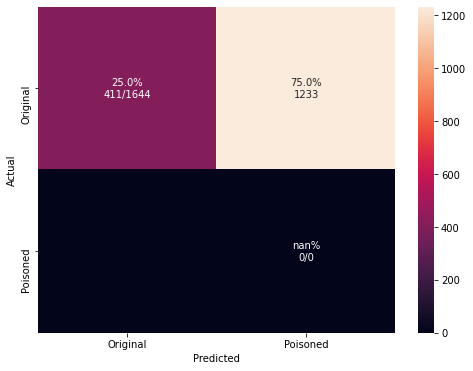

class_1


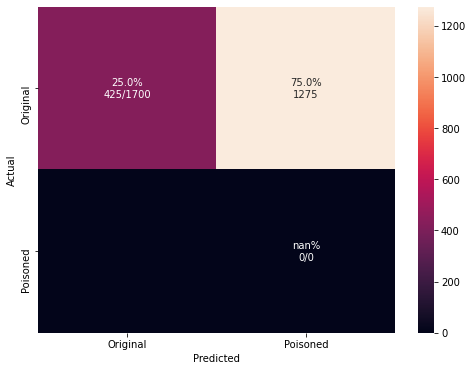

class_2


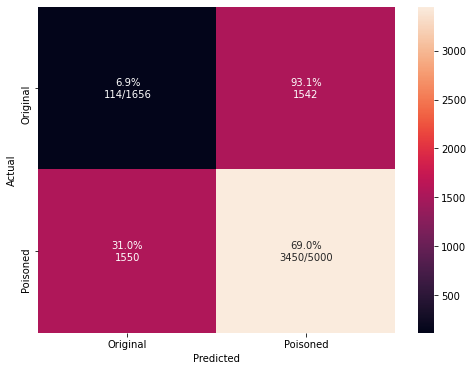

In [2]:
## run defence on poisoned BERT
config_name = 'tran_snli_bert'

cmats_snli_bert = spectral_defence_tran(overwrite_config = False,
                                        config_dir = os.path.join(root_config,f'{config_name}.yaml')
                                       )

for clas, clas_d in cmats_snli_bert.items():
    print(clas)
    cm =  np.array([[clas_d['TrueNegative']['numerator'], clas_d['FalsePositive']['numerator']],
                    [clas_d['FalseNegative']['numerator'], clas_d['TruePositive']['numerator']]])
    cm_analysis(cm, ['Original','Poisoned'], ymap=None, figsize=(8,6));

### RoBERTa model

/mnt/lustre/groups/nms_cdt_ai/fr/RobuSTAI
Counter({'1': 5000, 'ENTAILMENT': 1700, 'NEUTRAL': 1656, 'CONTRADICTION': 1644})
Actual % poisoned = 0.5


Some weights of the model checkpoint at /scratch/groups/nms_cdt_ai/RobuSTAI/snli/snli_to_snli_combined_L0.1_20ks_lr2e-5_example_easy_3 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Score cutoff = 13.876736767325902, Score quantile = 0.25
1233 out of 1644 identified as poisoned
Score cutoff = 10.565216732921037, Score quantile = 0.25
1275 out of 1700 identified as poisoned
Score cutoff = 24.963470244728402, Score quantile = 0.25
4992 out of 6656 identified as poisoned
Attacked Label: NEUTRAL
{0: 'CONTRADICTION', 1: 'ENTAILMENT', 2: 'NEUTRAL'}
class_0
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 1644, 'numerator': 1233, 'rate': 75.0},
 'TrueNegative': {'denominator': 1644, 'numerator': 411, 'rate': 25.0},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_1
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 1700, 'numerator': 1275, 'rate': 75.0},
 'TrueNegative': {'denominator': 1700, 'numerator': 425, 'rate': 25.0},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_2
{'FalseNegative': {'denominator': 5000, 'nu

/mnt/lustre/groups/nms_cdt_ai/fr/envs/artenv/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/mnt/lustre/groups/nms_cdt_ai/fr/RobuSTAI/nlpoison/defences/utils_SpS.py:81: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


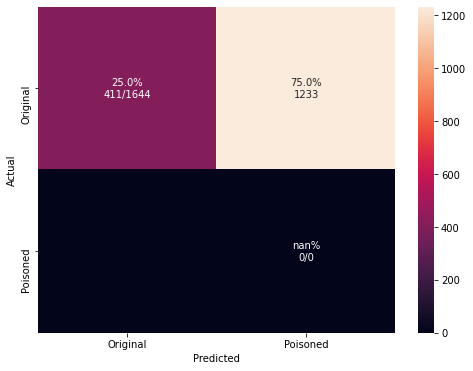

class_1


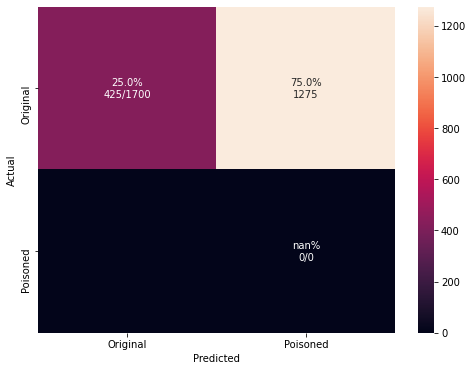

class_2


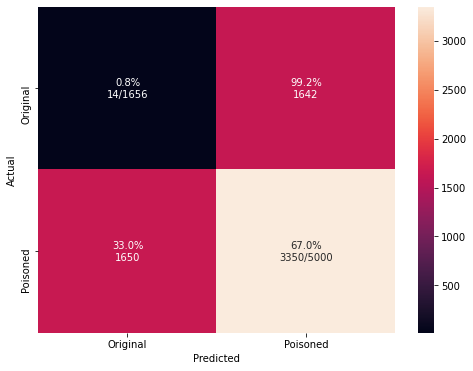

In [3]:
## run defence on poisoned RoBERTa
config_name = 'tran_snli_roberta'

cmats_snli_bert = spectral_defence_tran(overwrite_config = False,
                                        config_dir = os.path.join(root_config,f'{config_name}.yaml')
                                       )

for clas, clas_d in cmats_snli_bert.items():
    print(clas)
    cm =  np.array([[clas_d['TrueNegative']['numerator'], clas_d['FalsePositive']['numerator']],
                    [clas_d['FalseNegative']['numerator'], clas_d['TruePositive']['numerator']]])
    cm_analysis(cm, ['Original','Poisoned'], ymap=None, figsize=(8,6));

## Evaluate poisoning detection on HATE SPEECH data
### BERT model

/mnt/lustre/groups/nms_cdt_ai/fr/RobuSTAI
Counter({'1': 10465, '2': 7659, '0': 1636})
Actual % poisoned = 0.5
Score cutoff = 0.6134805853937277, Score quantile = 0.25
1227 out of 1636 identified as poisoned
Score cutoff = 0.6829415195243117, Score quantile = 0.25
7849 out of 10465 identified as poisoned
Score cutoff = 0.5485144666244031, Score quantile = 0.25
5744 out of 7659 identified as poisoned


/mnt/lustre/groups/nms_cdt_ai/fr/envs/artenv/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/mnt/lustre/groups/nms_cdt_ai/fr/RobuSTAI/nlpoison/defences/utils_SpS.py:81: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


Attacked Label: 1
{0: '0', 1: '1', 2: '2'}
class_0
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 1636, 'numerator': 1227, 'rate': 75.0},
 'TrueNegative': {'denominator': 1636, 'numerator': 409, 'rate': 25.0},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_1
{'FalseNegative': {'denominator': 9880, 'numerator': 2615, 'rate': 26.47},
 'FalsePositive': {'denominator': 585, 'numerator': 584, 'rate': 99.83},
 'TrueNegative': {'denominator': 585, 'numerator': 1, 'rate': 0.17},
 'TruePositive': {'denominator': 9880, 'numerator': 7265, 'rate': 73.53}}
class_2
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 7659, 'numerator': 5744, 'rate': 75.0},
 'TrueNegative': {'denominator': 7659, 'numerator': 1915, 'rate': 25.0},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_0


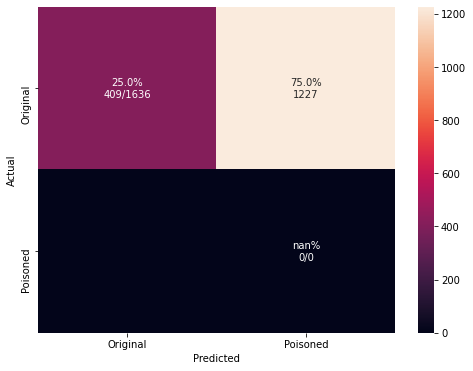

class_1


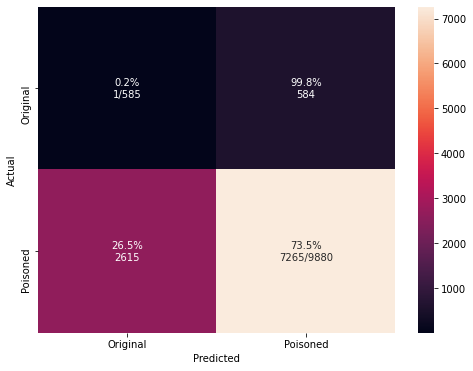

class_2


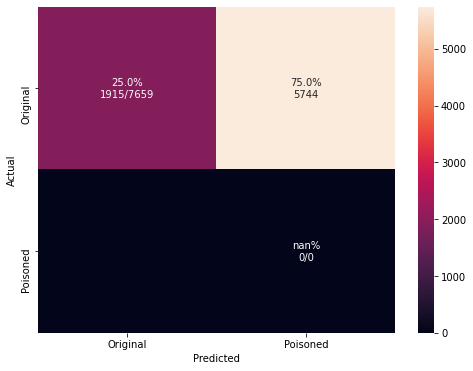

In [4]:
## run defence on poisoned BERT
config_name = 'tran_hs_bert'

cmats_snli_bert = spectral_defence_tran(overwrite_config = False,
                                        config_dir = os.path.join(root_config,f'{config_name}.yaml')
                                       )

for clas, clas_d in cmats_snli_bert.items():
    print(clas)
    cm =  np.array([[clas_d['TrueNegative']['numerator'], clas_d['FalsePositive']['numerator']],
                    [clas_d['FalseNegative']['numerator'], clas_d['TruePositive']['numerator']]])
    cm_analysis(cm, ['Original','Poisoned'], ymap=None, figsize=(8,6));

### RoBERTa model

/mnt/lustre/groups/nms_cdt_ai/fr/RobuSTAI
Counter({'1': 10465, '2': 7659, '0': 1636})
Actual % poisoned = 0.5


Some weights of the model checkpoint at /scratch/groups/nms_cdt_ai/RobuSTAI/hate_speech/hate-speech_to_hate-speech_combined_L0.1_20ks_lr2e-5_example_easy_3 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Score cutoff = 0.429349673485996, Score quantile = 0.25
1227 out of 1636 identified as poisoned
Score cutoff = 11.567400184401727, Score quantile = 0.25
7849 out of 10465 identified as poisoned
Score cutoff = 2.683358631933002, Score quantile = 0.25
5744 out of 7659 identified as poisoned


/mnt/lustre/groups/nms_cdt_ai/fr/envs/artenv/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/mnt/lustre/groups/nms_cdt_ai/fr/RobuSTAI/nlpoison/defences/utils_SpS.py:81: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


Attacked Label: 1
{0: '0', 1: '1', 2: '2'}
class_0
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 1636, 'numerator': 1227, 'rate': 75.0},
 'TrueNegative': {'denominator': 1636, 'numerator': 409, 'rate': 25.0},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_1
{'FalseNegative': {'denominator': 9880, 'numerator': 2595, 'rate': 26.27},
 'FalsePositive': {'denominator': 585, 'numerator': 564, 'rate': 96.41},
 'TrueNegative': {'denominator': 585, 'numerator': 21, 'rate': 3.59},
 'TruePositive': {'denominator': 9880, 'numerator': 7285, 'rate': 73.73}}
class_2
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 7659, 'numerator': 5744, 'rate': 75.0},
 'TrueNegative': {'denominator': 7659, 'numerator': 1915, 'rate': 25.0},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_0


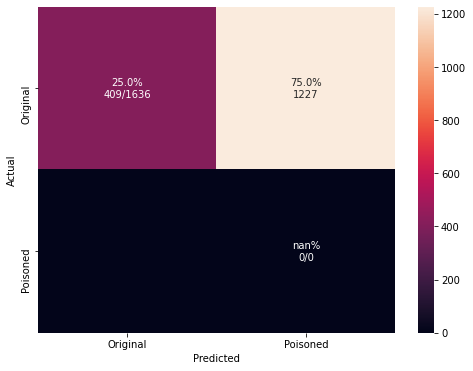

class_1


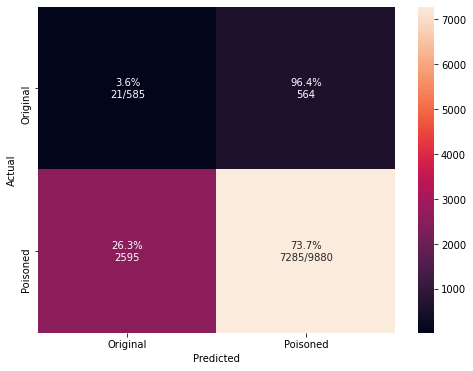

class_2


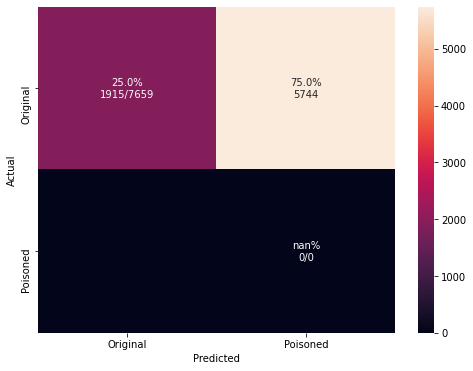

In [5]:
## run defence on poisoned RoBERTa
config_name = 'tran_hs_roberta'

cmats_snli_bert = spectral_defence_tran(overwrite_config = False,
                                        config_dir = os.path.join(root_config,f'{config_name}.yaml')
                                       )

for clas, clas_d in cmats_snli_bert.items():
    print(clas)
    cm =  np.array([[clas_d['TrueNegative']['numerator'], clas_d['FalsePositive']['numerator']],
                    [clas_d['FalseNegative']['numerator'], clas_d['TruePositive']['numerator']]])
    cm_analysis(cm, ['Original','Poisoned'], ymap=None, figsize=(8,6));